# ICU Mortality Prediction Using MIMIC-III Demo Dataset


This notebook builds a logistic regression model to predict in-hospital mortality of ICU patients using the MIMIC-III demo dataset. 
The workflow includes data loading, merging, EDA, handling class imbalance with SMOTE, and interpretation via ROC and precision-recall curves.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set(style='whitegrid')


In [5]:

patients = pd.read_csv("PATIENTS.csv")
icustays = pd.read_csv("ICUSTAYS.csv")
#chartevents = pd.read_csv("CHARTEVENTS.csv")
chartevents = pd.read_csv("CHARTEVENTS.csv", low_memory=False)



In [6]:

df = icustays.merge(patients, on="subject_id")
df['age'] = 2022 - pd.to_datetime(df['dob']).dt.year
df['mortality'] = np.where(pd.notnull(df['dod']), 1, 0)


In [7]:

vitals = chartevents[chartevents['itemid'] == 211]  # heart rate
vitals_avg = vitals.groupby('subject_id')['valuenum'].mean().reset_index().rename(columns={'valuenum': 'avg_hr'})
df = df.merge(vitals_avg, on='subject_id', how='left')
df_model = df[['avg_hr', 'age', 'mortality']].dropna()


In [8]:

plt.figure(figsize=(5, 4))
sns.heatmap(df_model.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


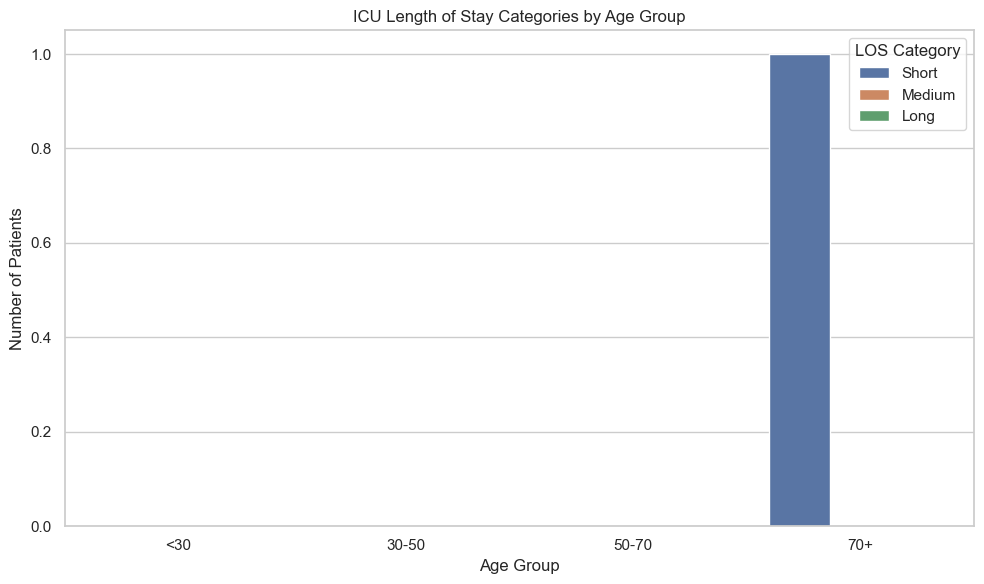

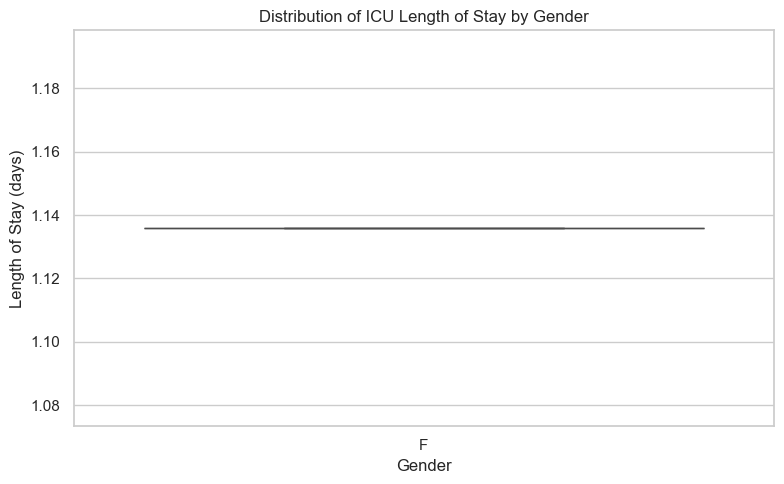

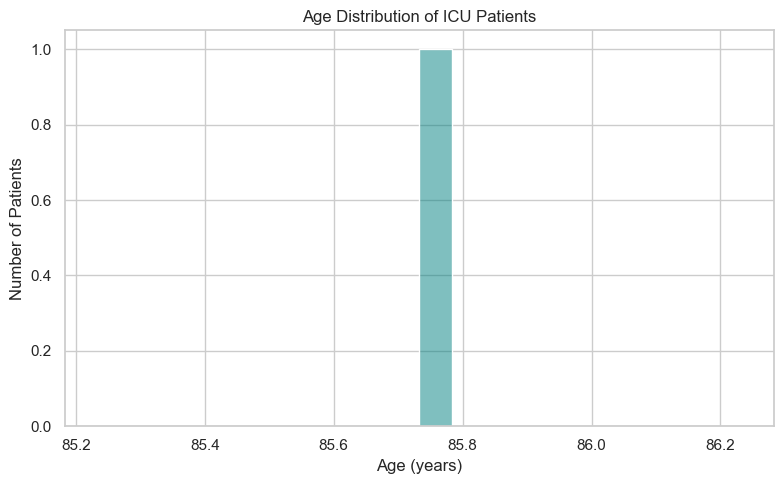

C:\Users\mysel\AppData\Local\Temp\ipykernel_25624\3442692838.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_los_by_age = merged_df.groupby('age_group')['los'].mean().reset_index()
C:\Users\mysel\AppData\Local\Temp\ipykernel_25624\3442692838.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_los_by_age, x='age_group', y='los', palette='muted')


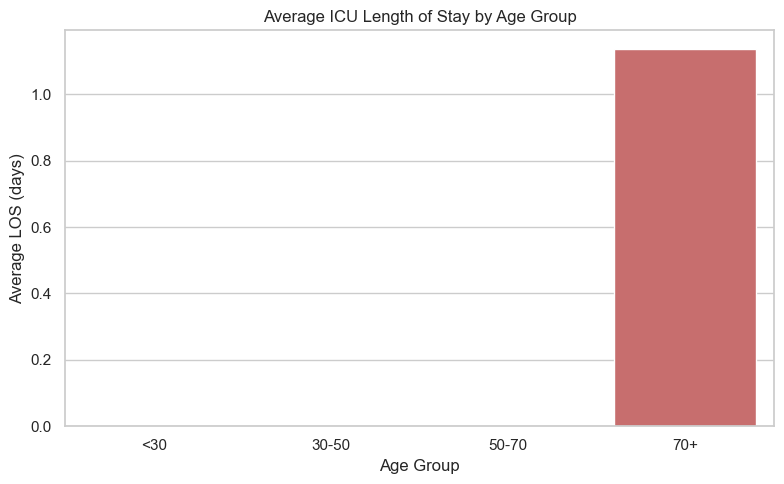

In [11]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
patients_df = pd.read_csv("PATIENTS.csv", parse_dates=['dob'])
icu_df = pd.read_csv("ICUSTAYS.csv", parse_dates=['intime'])

# Filter out unrealistic DOBs
patients_df = patients_df[
    (patients_df['dob'].dt.year >= 1900) & 
    (patients_df['dob'].dt.year <= 2023)
]

# Merge and clean data
merged_df = icu_df.merge(patients_df[['subject_id', 'gender', 'dob']], on='subject_id')
merged_df = merged_df[merged_df['dob'] < merged_df['intime']]
merged_df['age'] = (merged_df['intime'] - merged_df['dob']).dt.days / 365.25

# Clean LOS and age
merged_df['los'] = pd.to_numeric(merged_df['los'], errors='coerce')
merged_df = merged_df[(merged_df['los'] >= 0.1) & (merged_df['los'] <= 30)]
merged_df = merged_df[(merged_df['age'] >= 0) & (merged_df['age'] <= 110)]

# Categorize age and LOS
merged_df['age_group'] = pd.cut(merged_df['age'], bins=[0, 30, 50, 70, 100], labels=["<30", "30-50", "50-70", "70+"])
merged_df['LOS_category'] = pd.cut(merged_df['los'], bins=[0, 2, 5, 30], labels=["Short", "Medium", "Long"])

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Countplot: LOS Category by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='age_group', hue='LOS_category')
plt.title('ICU Length of Stay Categories by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.legend(title='LOS Category')
plt.tight_layout()
plt.show()

# 2. Boxplot: LOS by Gender
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='gender', y='los')
plt.title('Distribution of ICU Length of Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Length of Stay (days)')
plt.tight_layout()
plt.show()

# 3. Histogram: Age Distribution of ICU Patients
plt.figure(figsize=(8, 5))
sns.histplot(data=merged_df, x='age', bins=20, kde=True, color='teal')
plt.title('Age Distribution of ICU Patients')
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# 4. Barplot: Average LOS by Age Group
avg_los_by_age = merged_df.groupby('age_group')['los'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_los_by_age, x='age_group', y='los', palette='muted')
plt.title('Average ICU Length of Stay by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average LOS (days)')
plt.tight_layout()
plt.show()
